# VideoMAEv2 model availables

### Pre-train

| Model | Config | Dataset | 
| :---: | :----  | :-----: | 
| ViT-giant | vit_g_hybrid_pt_1200e | UnlabeledHybrid | 

### Fine-tune
| Model | Config | Dataset | Pre-train | Post-pre-train |
| :---: | :----  | :-----: | :-------: | :------------: |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_ft | K710 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k400_ft | K400 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k400_ft | K400 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_k600_ft | K600 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_ssv2_ft | SSv2 | UnlabeledHybrid | None |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_ucf101_ft | UCF101 | UnlabeledHybrid | K710 |
| ViT-giant | vit_g_hybrid_pt_1200e_k710_it_hmdb51_ft | HMDB51 | UnlabeledHybrid | K710 |

### Distillation from giant
|  Model  | Dataset | Teacher Model  |
| :-----: | :-----: | :-----------: |
| ViT-small | K710 | vit_g_hybrid_pt_1200e_k710_ft |
| ViT-base | K710 | vit_g_hybrid_pt_1200e_k710_ft | 

### Model details

|  model  | frame channels | frame input | frame size (H,W) | tubelet size | patch size | emb dim | output tensor | mem(GB) |
| :-----: | :-----: | :-----------: | :-----: | :-----: | :-----------: | :-----: | :-----: |:----|
| giant | 3 | 16 | (224,224) | 2 | (14,14) | 1408 | [8,16,16,1408] | 4.0 |
| base | 3 | 16 | (224,224) | 2 | (16,16) | 768 | [8,14,14,768] | 0.4|
| small | 3 | 16 | (224,224) | 2 | (16,16) | 384 | [8,14,14,356] | 0.1|
 


<div style="overflow-x: auto;">

## PSPI from (Action Units)
Pain expression is widely characterized by the activation of a small set of facial muscles and coded by a set of
corresponding actions units (AUs): 
| Action units  | Meaning              | Range   |
|----------------|----------------------|---------|
| AU 4          | brow lowering        | 0 to 5  |
| AU 6 and AU 7 | orbital tightening   | 0 to 5  |
| AU 9 and AU 10| levator labii raise  | 0 to 5  |
| AU 43         | eye closure          | 0 or 1  |
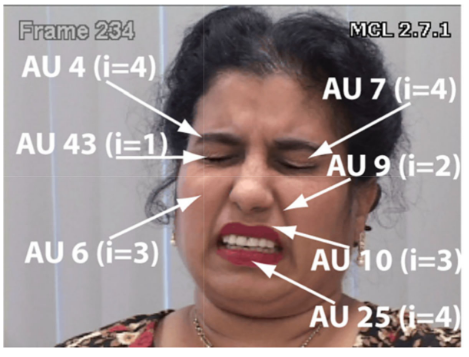

STEPS for preprocessing:
1) Align faces by fixing the inter-ocular distance.
2) Compute mean facial shape by averaging all of the landmark points in the roughly aligned faces.
3) Warp each face in the database to the average face using piece-wise linear warping,where the facial pieces are formed using Delaunay triangulation.
4) Crop out the normalized faces by forming a mask with the convex hull of the landmark points resulting in 224×224 images

# COde

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentivePooling(nn.Module):
    """
    Simple attentive pooling head + linear classifier with an explain() method
    that computes token-level relevance using an LRP-style epsilon rule.
    Assumptions:
      - Single example (batch_size=1) for explain(); extend as needed.
      - Single attention head (you can extend to multi-head by summing/averaging heads).
    """
    def __init__(self, embed_dim, hidden_dim, num_classes):
        super().__init__()
        # optionally use projections; here we show simple linear q/k/v
        self.q_proj = nn.Linear(embed_dim, hidden_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, hidden_dim, bias=False)
        self.v_proj = nn.Linear(embed_dim, hidden_dim, bias=False)

        # classifier that consumes pooled vector
        self.classifier = nn.Linear(hidden_dim, num_classes, bias=True)

        # cache for explanations
        self._cache = {}

    def forward(self, x):
        # x: (B, T, D)
        q = self.q_proj(x)        # (B, T, H)
        k = self.k_proj(x)        # (B, T, H)
        v = self.v_proj(x)        # (B, T, H)

        # simple scaled dot-product attention (single head)
        scores = torch.matmul(q, k.transpose(-2, -1)) / (q.size(-1) ** 0.5)  # (B, T, T)
        attn = F.softmax(scores, dim=-1)  # (B, T, T)

        # pooled vector: average of "query" positions; for pooling we might use a special query (e.g., cls),
        # but for simplicity pool as mean over query positions: here we take the first position as query (like CLS)
        pooled = torch.matmul(attn[:, 0:1, :], v)  # (B, 1, H)  -> pooled vector for position 0
        pooled = pooled.squeeze(1)  # (B, H)

        logits = self.classifier(pooled)  # (B, C)

        # cache activations needed for explanation (detach where appropriate)
        self._cache = {
            'x': x.detach(),
            'q': q.detach(),
            'k': k.detach(),
            'v': v.detach(),
            'attn': attn.detach(),
            'pooled': pooled.detach(),
            'logits': logits.detach(),
            'classifier_weight': self.classifier.weight.detach(),  # (C, H)
            'classifier_bias': self.classifier.bias.detach() if self.classifier.bias is not None else None
        }

        return logits

    def explain(self, target=None, eps=1e-6):
        """
        Compute token-level relevance scores for the target class (batch assumed to be size 1).
        Returns: relevance per token: shape (T,)
        """
        cache = self._cache
        if not cache:
            raise RuntimeError("No activations cached. Run forward(...) first on the input you want to explain.")

        attn = cache['attn'][0]      # (T_query, T_key) -> we used query pos 0, so attn[0] is (T_key,)
        v = cache['v'][0]            # (T, H)
        pooled = cache['pooled'][0]  # (H,)
        logits = cache['logits'][0]  # (C,)
        Wc = cache['classifier_weight']  # (C, H)

        # choose target class
        if target is None:
            target = torch.argmax(logits).item()

        # 1) initialize relevance at output: use the target logit value as relevance mass
        R_out = logits[target].detach()  # scalar
        if R_out.abs() < eps:
            # fallback to 1.0 if logit is tiny
            R_out = torch.tensor(1.0, device=logits.device)

        # 2) propagate through linear classifier -> relevance on pooled dims
        # classifier logit = Wc[target] @ pooled + b
        w = Wc[target]  # (H,)
        # contribution per pooled dimension
        z = pooled * w             # (H,)
        z_sum = z.sum() + eps
        R_pooled = (z / z_sum) * R_out   # (H,)
        # keep as vector

        # 3) propagate pooled relevance through pooling = sum_j alpha_j * v_j
        # pooled[d] = sum_j attn_j * v_j[d]   where attn_j = attn[0, j] in our simplified design
        alpha = attn[0] if attn.dim() == 2 else attn  # shape (T,)
        # numerator: (T, H)
        numer = alpha.unsqueeze(1) * v   # (T, H)
        denom = numer.sum(dim=0, keepdim=True) + eps  # (1, H)
        # relevance per token and hidden-dim
        R_tokens_hidden = numer / denom * R_pooled.unsqueeze(0)  # (T, H)
        # token-level relevance score (sum over hidden dims)
        token_relevance = R_tokens_hidden.sum(dim=1)  # (T,)

        # normalize for readability (optional)
        token_relevance = token_relevance / (token_relevance.sum().abs() + eps)

        return token_relevance.detach()

# Example usage:
if __name__ == "__main__":
    B, T, D = 1, 12, 64
    hidden_dim = 32
    num_classes = 3

    model = AttentivePooling(embed_dim=D, hidden_dim=hidden_dim, num_classes=num_classes)
    x = torch.randn(B, T, D)
    logits = model(x)
    # pick predicted class
    pred = torch.argmax(logits, dim=-1).item()
    relevance = model.explain(target=pred)  # (T,)
    print("Token relevance:", relevance)


Token relevance: tensor([-0.2196, -0.7922,  0.1712,  0.0292, -0.2969,  0.1679,  0.8983,  0.6672,
         0.3204, -0.5252,  0.1443,  0.4353])


In [13]:
import os
import cv2
import numpy as np
import tqdm


video_path_folder = "/equilibrium/fvilli/PainAssessmentVideo/partA/video/video_frontalized_interpolated_mirror"
video_path_list = []
tot_frames = 0
for root, dirs, files in os.walk(video_path_folder):
  for file in files:
    if file.endswith(".mp4") and '$' not in file:
      video_path_list.append(os.path.join(root, file))
dict_video_size_count = {}

for video_path in tqdm.tqdm(video_path_list):
  cap = cv2.VideoCapture(video_path)
  if not cap.isOpened():
    print("Error opening video file")
    continue
  # width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  # height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  # size = (width, height)
  # if size not in dict_video_size_count:
  #   dict_video_size_count[size] = 0
  # dict_video_size_count[size] += 1
  tot_frames += int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  cap.release()
print(dict_video_size_count)
print(f"Total frames across all videos: {tot_frames}")


100%|██████████| 8700/8700 [00:33<00:00, 260.98it/s]

{}
Total frames across all videos: 1252284


In [4]:
import os
import numpy as np
import custom.tools as tools
import cv2

image_folder_path = "/media/villi/TOSHIBA EXT/test_video/test_Oct_17/history_run_no_quadrant_MC_fullfeats_3d_pos_mask_2628639_ATTENTIVE_JEPA_lechuck_1760555014/1760555019718_VIDEOMAE_v2_S_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/train_ATTENTIVE_JEPA/k0_cross_val/k0_cross_val_sub_0/cross_attention_1760606920/log_attention/images"
list_images_subject = []
for root, dirs, files in os.walk(image_folder_path):
  for file in files:
    if file.endswith(".png") and 'subject_' in file:
      list_images_subject.append(os.path.join(root, file))

list_frames = []
for image_path in list_images_subject:
  image = cv2.imread(image_path)
  list_frames.append(image)
video_output_path = os.path.join(image_folder_path, f"subject_tot{len(list_images_subject)}.mp4")

tools.generate_video_from_list_frame(list_frames, video_output_path, fps=1,already_bgr=True)


Video saved to /media/villi/TOSHIBA EXT/test_video/test_Oct_17/history_run_no_quadrant_MC_fullfeats_3d_pos_mask_2628639_ATTENTIVE_JEPA_lechuck_1760555014/1760555019718_VIDEOMAE_v2_S_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/train_ATTENTIVE_JEPA/k0_cross_val/k0_cross_val_sub_0/cross_attention_1760606920/log_attention/images/subject_tot53.mp4


In [105]:
import pickle
import os 
import cv2
import numpy as np
import tqdm

video_path_folder = "/equilibrium/fvilli/PainAssessmentVideo/partA/video/video_frontalized_interpolated_mirror"
grid_size = (14, 14)
video_path_list = []
for root, dirs, files in os.walk(video_path_folder):
  for file in files:
    if file.endswith(".mp4") and '$' not in file:
      video_path_list.append(os.path.join(root, file))

tot_frames = 0
full_black_count = np.zeros((len(video_path_list), grid_size[0], grid_size[1]), dtype=int)
mean_value_matrix = np.zeros((len(video_path_list), grid_size[0], grid_size[1]), dtype=float)
threshold = 240  # Threshold to consider a cell as "full black"
threshold_count = np.zeros((len(video_path_list), grid_size[0], grid_size[1]), dtype=int)
for video_idx, video_path in enumerate(tqdm.tqdm(video_path_list)):
  cap = cv2.VideoCapture(video_path)
  if not cap.isOpened():
    print("Error opening video file:", video_path)
    continue
  frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  grid_h = frame_height // grid_size[0]
  grid_w = frame_width // grid_size[1]
  tot_frames += frame_count
  for frame_idx in range(frame_count):
    ret, frame = cap.read()
    if not ret:
      break
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    for i in range(grid_size[0]):
      for j in range(grid_size[1]):
        cell = gray_frame[i*grid_h:(i+1)*grid_h, j*grid_w:(j+1)*grid_w]
        mean_value_matrix[video_idx, i, j] += np.mean(cell)
        if np.all(cell == 0):
          full_black_count[video_idx, i, j] += 1
        if np.mean(cell) < threshold:
          threshold_count[video_idx, i, j] += 1
  cap.release()

pkl_file = {
  "video_path_list": video_path_list,
  "full_black_count": full_black_count,
  'mean_value_matrix': mean_value_matrix,
  "threshold_count": threshold_count,
  "threshold": threshold,
  "grid_size": grid_size,
  "total_frames": tot_frames
}

with open(os.path.join(video_path_folder, f"video_analysis_grid_{grid_size[0]}_{grid_size[1]}.pkl"), "wb") as f:
  pickle.dump(pkl_file, f)

KeyboardInterrupt: 

In [3]:
import pandas as pd
import os
from pathlib import Path


cvs_path = "/equilibrium/fvilli/TRAIN_tests/history_run_QUAdrant_MC_8850_ATTENTIVE_JEPA_dune.micc_1760114840/1760114852343_VIDEOMAE_v2_S_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/train_ATTENTIVE_JEPA/k0_cross_val/test.csv"
df = pd.read_csv(cvs_path,sep='\t',dtype={'class_id':str,'sample_name':str})
cols = df.columns.tolist()
list_class = df['class_id'].unique().tolist()
new_df = pd.DataFrame(columns=cols)
for c in list_class:
  class_df = df[df['class_id'] == c]
  new_df = pd.concat([new_df, class_df.sample(n=5, random_state=42)], axis=0)
  
basepath = os.path.dirname(cvs_path)
new_df.to_csv(os.path.join(basepath, f"{Path(cvs_path).stem}_xattn_debug.csv"), index=False, sep='\t')

In [6]:
import pandas as pd
import os
from pathlib import Path


csv_path = "/equilibrium/fvilli/TRAIN_tests/history_run_no_quadrant_NPvsPA4_1012543_ATTENTIVE_JEPA_lechuck_1760002086/1760002091264_VIDEOMAE_v2_S_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/train_ATTENTIVE_JEPA/k0_cross_val/test.csv"

df = pd.read_csv(csv_path, sep='\t')
list_subjects = df['subject_id'].unique().tolist()

subject_targets = [31,52,6,1,
                   36,41,56,82] # FLOP
new_df = pd.DataFrame(columns=df.columns.tolist())

for s in subject_targets:
  subject_df = df[df['subject_id'] == s]
  new_df = pd.concat([new_df, subject_df], axis=0)
  
basepath = os.path.dirname(csv_path)
new_df.to_csv(os.path.join(basepath, f"{Path(csv_path).stem}_selected_subjects.csv"), index=False, sep='\t')


In [ ]:
# CLASS New csv for xattn plots
import pandas as pd
import os

csv_path = "/equilibrium/fvilli/TRAIN_tests/history_run_3d_pos_3838663_ATTENTIVE_JEPA_targaryen_1759764521/1759764542779_VIDEOMAE_v2_S_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/train_ATTENTIVE_JEPA/k0_cross_val/test.csv"
df = pd.read_csv(csv_path, sep='\t')
list_subjects = df['subject_id'].unique().tolist()
classes = [0,1,2,3]
class_id_target = 4
cols = df.columns.tolist()
new_df = pd.DataFrame(columns=cols)

for subject in list_subjects:
  df_sub = df[(df['subject_id'] == subject) & (df['class_id'] == class_id_target)]
  new_df = pd.concat([new_df, df_sub.sample(n=3, random_state=42)], ignore_index=True)

for c in classes:
  if c == class_id_target:
    continue
  df_sub = df[df['class_id'] == c]
  new_df = pd.concat([new_df, df_sub.sample(n=1, random_state=42)], ignore_index=True)

basepath = os.path.dirname(csv_path)
new_df.to_csv(os.path.join(basepath, "test_cross_debug_PA4_3_samples.csv"), sep='\t', index=False)  
print(f'New csv saved in {os.path.join(basepath, "test_cross_debug_PA4_3_samples.csv")}')

New csv saved in /equilibrium/fvilli/TRAIN_tests/history_run_3d_pos_3838663_ATTENTIVE_JEPA_targaryen_1759764521/1759764542779_VIDEOMAE_v2_S_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/train_ATTENTIVE_JEPA/k0_cross_val/test_cross_debug_PA4_3_samples.csv


In [5]:
tmp_1 = 1342-790 # 5 minutes
print(f'Time for {tmp_1} samples in 5 minutes')
tot = 13000
print(f'Expected time: {tot/tmp_1 * 5} minutes')

Time for 552 samples in 5 minutes
Expected time: 117.7536231884058 minutes


In [12]:
import safetensors.torch
import torch

path = "/equilibrium/fvilli/CAER_frontalize/feats/whole_front_full_combined/Neutral/0619.safetensors"
part = "upper_left"
path = f"/equilibrium/fvilli/CAER_frontalize/feats/whole_front_full/{part}/Neutral/0619${part}.safetensors"

data = safetensors.torch.load_file(path)

In [13]:
data['list_frames']

tensor([[ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]],
       dtype=torch.int32)

In [ ]:
import os
import pandas
import tqdm

dataset_path = "/equilibrium/fvilli/CAER_frontalize"
new_csv_name = "caer_frontalize_labels.csv"


list_videos = []
for root, dirs, files in os.walk(dataset_path):
  for file in files:
    if file.endswith(".avi"):
      list_videos.append(os.path.join(root, file))

emotion_to_int = {
  'anger':0,
  'disgust':1,
  'fear':2,
  'happy':3,
  'neutral':4,
  'sad':5,
  'surprise':6
}

strig_to_id = {
  'train':2,
  'validation':1,
  'test':0
}

cols = ['subject_id',
        'subject_name',
        'class_id',
        'class_name',
        'sample_id',
        'sample_name']

if dataset_path != "/equilibrium/fvilli/CAER": # to mantain consistency with original labels
  original_dataset_df = "/equilibrium/fvilli/CAER/caer_labels.csv"
  original_df = pandas.read_csv(original_dataset_df,sep='\t',dtype={'sample_name':str})
else:
  original_df = None

new_df = pandas.DataFrame(columns=cols)
entry = []
count_sample_id = 1      
for video in tqdm.tqdm(list_videos,desc="Processing videos"):
  split_video = video.split('/')
  subject_name = "/".join(split_video[-3:-1])
  sample_name = split_video[-1].split('.')[0]
  class_id = emotion_to_int[split_video[-2].lower()]
  class_name = split_video[-2].lower()
  subject_id = strig_to_id[split_video[-3].lower()]
  if original_df is not None: # to sample_id consistency with original csv
    mask = (original_df['subject_name'] == subject_name) & (original_df['sample_name'] == sample_name)
    if not mask.any():
      raise ValueError(f'Error: sample not found in original df: {subject_name}, {sample_name}')
    sample_id = original_df['sample_id'][mask].values[0]
  else:
    sample_id = count_sample_id
  entry.append([subject_id,subject_name,class_id,class_name,sample_id,sample_name])
  count_sample_id += 1
  
new_df = pandas.DataFrame(entry, columns=cols)
# new_df.to_csv("caer_labels.csv",index=False,sep='\t')
# save dataframe to csv
new_df.to_csv(os.path.join(dataset_path,new_csv_name),index=False,sep='\t')
print(f"Saved dataframe to {os.path.join(dataset_path,new_csv_name)}")

In [ ]:
import cv2
import tqdm
import pandas 
import os


dataset_path = "/equilibrium/fvilli/DATASETS/CelebV-HQ/video"
csv_path = "/equilibrium/fvilli/DATASETS/CelebV-HQ/starting_point/samples.csv"

original_df = pandas.read_csv(csv_path,sep='\t',dtype={'sample_name':str})

list_videos = []
for root, dirs, files in tqdm.tqdm(os.walk(dataset_path), desc="Searching for videos"):
  for file in files:
    if file.endswith(".mp4"):
      list_videos.append(os.path.join(root, file))

df_entry = []
for video in tqdm.tqdm(list_videos,desc="Processing videos"):
  cap = cv2.VideoCapture(video)
  if not cap.isOpened():
    print(f"Error opening video file: {video}")
  else:
    FPS = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / FPS
    if 'caer' in dataset_path.lower():
      class_name = video.split('/')[-2].lower()
      sample_name = video.split('/')[-1].split('.')[0]
      subject_name = "/".join(video.split('/')[-3:-1])
    elif 'celeb' in dataset_path.lower():
      sample_name = video.split('/')[-1].split('.')[0]
      class_name = original_df[original_df['sample_name']==sample_name]['class_name'].values[0]
      subject_name = video.split('/')[-2].split('.')[0]
    else:
      raise ValueError('Dataset path not recognized')
    
    mask = (original_df['subject_name'] == subject_name) & (original_df['sample_name'] == sample_name)
    if mask.any() == 0:
      raise ValueError(f'Error: sample not found in original df: {subject_name}, {sample_name}')
    sample_id = original_df['sample_id'][mask].values[0]
    df_entry.append([sample_id,sample_name,class_name,FPS,frame_count,duration])
  cap.release()

df_videos = pandas.DataFrame(df_entry,columns=['sample_id','sample_name','class_name','FPS','frame_count','duration'])
df_videos.to_csv(os.path.join(os.path.dirname(csv_path),"videos_info.csv"),index=False,sep='\t')


In [ ]:
import os
import cv2
import tqdm

video_root_folder = "partA/video/video_frontalized_interpolated_resolution_original" # "/equilibrium/fvilli/CAER_frontalize/"
plot_name = "video_resolution_distribution_original_frontalized_Biovid.png"
video_ext = ".avi" if 'caer' in video_root_folder.lower() else ".mp4"

list_video_path = []
for root, dirs, files in os.walk(video_root_folder):
  for file in files:
    if file.endswith(video_ext) and '$' not in file:
      list_video_path.append(os.path.join(root, file))

dict_heights = {}
dict_widths = {}
for video_path_folder in tqdm.tqdm(list_video_path,desc="Getting video resolutions..."):
  cap = cv2.VideoCapture(video_path_folder)
  if not cap.isOpened():
    print(f"Error opening video file: {video_path_folder}")
    continue
  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  dict_heights[video_path_folder] = height
  dict_widths[video_path_folder] = width
  cap.release()

import matplotlib.pyplot as plt
import numpy as np

heights = np.array(list(dict_heights.values()))
widths = np.array(list(dict_widths.values()))

fig, ax = plt.subplots(2, 1, figsize=(8, 12))  # fixed order

# Global title
fig.suptitle(f"{'CAER' if 'caer' in video_root_folder.lower() else 'Biovid'} Frontalized Size Distribution", fontsize=16)

# First subplot: heights
ax[0].hist(heights, range=(0,600), bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Video Height Distribution')
ax[0].set_xlabel('Height (pixels)')
ax[0].set_ylabel('Frequency')

# Second subplot: widths
ax[1].hist(widths, range=(0,600), bins=30, color='salmon', edgecolor='black')
ax[1].set_title('Video Width Distribution')
ax[1].set_xlabel('Width (pixels)')
ax[1].set_ylabel('Frequency')

# Save and show
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for suptitle
plt.savefig(plot_name)
plt.show()




In [9]:
import safetensors.torch
import tqdm
import os
feats_path = "/equilibrium/fvilli/CAER_frontalize/feats/whole_front_full/upper_left"
list_data = []
for root, dirs, files in os.walk(feats_path):
  for file in files:
    if file.endswith(".safetensors"):
      list_data.append(os.path.join(root, file))
      
for data_path in tqdm.tqdm(list_data,desc="Checking features..."):
  data = safetensors.torch.load_file(data_path)
  if 0 in data['features'].shape:
    print(f"Error in {data_path}, shape: {data['features'].shape}")

Checking features...: 100%|██████████| 9052/9052 [03:46<00:00, 40.02it/s]


# Attention Masked Plot with image overlay

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
from pathlib import Path
import tqdm
import os

def get_one_video_per_subject(video_path_folder):
  folder_list = [f for f in os.listdir(video_path_folder) if os.path.isdir(os.path.join(video_path_folder, f))]
  lst = []
  for folder in tqdm.tqdm(folder_list, desc="Getting one video per subject"):
    folder_path = os.path.join(video_path_folder, folder)
    for file in os.listdir(folder_path):
      if file.endswith(".mp4") and '$' not in file:
        lst.append(os.path.join(folder_path, file))
        break    
  return lst

                                                       
pkl_path = "/equilibrium/fvilli/PainAssessmentVideo/partA/video/video_frontalized_interpolated_mirror/video_analysis_grid_14_14.pkl"
mask_threshold = 7680 # threshold for mean_value_matrix to create boolean mask
list_video_per_subject = []
plot_all_subject = True

# --- Load pickle ---
if not Path(pkl_path).exists():
    raise FileNotFoundError(f"Pickle not found: {pkl_path}")
with open(pkl_path, "rb") as f:
  pkl_file = pickle.load(f)

# --- Compute boolean mask ---
mask_small = np.mean(pkl_file['mean_value_matrix'], axis=0) < mask_threshold  # (14,14)

folder_plot_path = None
if plot_all_subject:
  list_video_per_subject = get_one_video_per_subject(Path(pkl_path).parent)
  print(f"Found {len(list_video_per_subject)} videos, one per subject.")
  folder_plot_path = Path(pkl_path).parent / f"plots_grid_{mask_small.shape[0]}x{mask_small.shape[1]}_thr_{mask_threshold}"
  os.makedirs(folder_plot_path, exist_ok=True)
  print(f"Plots will be saved to: {folder_plot_path}")
else:
  list_video_per_subject = [f"{Path(pkl_path).parent}/071309_w_21/071309_w_21-BL1-081.mp4"]
  
# --- Load one video frame per subject ---
for ref_video_path in tqdm.tqdm(list_video_per_subject, desc="Processing videos"):
  if not Path(ref_video_path).exists():
    raise FileNotFoundError(f"Video not found: {ref_video_path}")
  
  cap = cv2.VideoCapture(ref_video_path)
  if not cap.isOpened():
    raise RuntimeError("Error opening video file")

  ret, frame = cap.read()
  cap.release()
  if not ret or frame is None:
    raise RuntimeError("Couldn't read first frame from video")

  # Convert to RGBA
  frame_rgba = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
  h, w = frame_rgba.shape[:2]

  # --- Compute mask ---
  mask_resized = cv2.resize(mask_small.astype(np.uint8), (w, h), interpolation=cv2.INTER_NEAREST).astype(bool)

  # --- Overlay coloring ---
  overlay_alpha_value = 150
  overlay = np.zeros_like(frame_rgba, dtype=np.uint8)
  overlay[mask_resized] = [255, 0, 0, overlay_alpha_value]   # red semi-transparent
  overlay[~mask_resized] = [0, 255, 0, overlay_alpha_value]  # green semi-transparent

  alpha = overlay[..., 3:4].astype(np.float32) / 255.0
  blended_rgb = (alpha * overlay[..., :3] + (1 - alpha) * frame_rgba[..., :3]).astype(np.uint8)
  final_img = np.concatenate([blended_rgb, np.full((h, w, 1), 255, dtype=np.uint8)], axis=2)

  # --- Draw grid borders (14×14) ---
  num_rows, num_cols = mask_small.shape
  step_y = h // num_rows
  step_x = w // num_cols

  grid_img = final_img.copy()
  line_color = (0, 0, 0, 128)  # black lines
  thickness = 1

  # Vertical lines
  for x in range(0, w, step_x):
    cv2.line(grid_img, (x, 0), (x, h), line_color, thickness)

  # Horizontal lines
  for y in range(0, h, step_y):
    cv2.line(grid_img, (0, y), (w, y), line_color, thickness)

  # --- Display ---
  plt.figure(figsize=(10, 6))
  plt.imshow(grid_img)
  plt.axis('off')
  plt.title(f"Red = Masked, Green = Unmasked \nThreshold = {mask_threshold} Grid Size = {num_rows}x{num_cols}\n\{Path(ref_video_path).stem}\n{pkl_path}")
  if folder_plot_path is None:
    plt.show()
  else:
    png_path = folder_plot_path / f"{Path(ref_video_path).stem}_grid_{num_rows}x{num_cols}_thr{mask_threshold}.png"
    plt.savefig(png_path)
    plt.close()



Getting one video per subject: 100%|██████████| 88/88 [00:00<00:00, 121.67it/s]


Found 87 videos, one per subject.
Plots will be saved to: /equilibrium/fvilli/PainAssessmentVideo/partA/video/video_frontalized_interpolated_mirror/plots_grid_14x14_thr_7680


Processing videos: 100%|██████████| 87/87 [00:31<00:00,  2.77it/s]


In [3]:
import cv2
import os
from pathlib import Path

folder_path = "/media/villi/TOSHIBA EXT/test_video/test_Oct_24/L1_Biovid_plot_xattn/history_run_no_quadrant_MC_fullfeats_3d_pos_mask_400ep_2978363_ATTENTIVE_JEPA_lechuck_1760789675/1760789684344_VIDEOMAE_v2_S_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/train_ATTENTIVE_JEPA/k0_cross_val/k0_cross_val_sub_0/video_embeddings_1761238026_split_chunks/tsne_logs_1761292327/tsne_plots_split_chunks/per_subject_tsne"
video_name = "per_subject_tsne_video.mp4"
img_path_list = []
for root, dirs, files in os.walk(folder_path):
  for file in files:
    if file.endswith(".png"):
      img_path_list.append(os.path.join(root, file))
      
img_path_list = sorted(img_path_list)
list_frames = []
for img_path in img_path_list:
  image = cv2.imread(img_path)
  list_frames.append(image)
video_output_path = os.path.join(folder_path, video_name)
fourcc = cv2.VideoWriter_fourcc(*"avc1")
width, height = list_frames[0].shape[1], list_frames[0].shape[0]
video_writer = cv2.VideoWriter(video_output_path, fourcc, 2, (list_frames[0].shape[1], list_frames[0].shape[0]))
for frame in list_frames:
  if frame.shape[1] != width or frame.shape[0] != height:
    frame = cv2.resize(frame, (width, height))
  video_writer.write(frame)
video_writer.release()


# 

# TSNE Plot

In [ ]:
import os
import pandas as pd
import openTSNE
import custom.tools as tools
import torch
from custom.helper import EMBEDDING_REDUCTION
import custom.helper as helper
import matplotlib.pyplot as plt
import time
import pickle
import torch
import tqdm
import numpy as np


def load_dict_data(root_folder_feats,sample_name,subject_name):
  tmp = ''
  if (('upper' in root_folder_feats.lower()) or ('bottom' in root_folder_feats.lower()) and ('left' in root_folder_feats.lower() or 'right' in root_folder_feats.lower())):
    tmp = f"${root_folder_feats.split('/')[-1]}"
  feature_path = os.path.join(root_folder_feats, subject_name, f'{sample_name}{tmp}.safetensors')
  dict_data = tools.load_dict_data(feature_path)
  return dict_data

def get_idx_for_plot(list_frames,threshold_for_plot):
  target_frame = threshold_for_plot * FPS
  if list_frames.ndim > 1:
    list_frames = list_frames.reshape(-1)
  mask = np.where(list_frames > target_frame)
  idx_frame = np.min(mask)
  idx_feats = (idx_frame + 1) // 2 # There is the 3D conv. in input so from 16 frames in input I have 8 frames in output
  return idx_frame, idx_feats, target_frame

FPS = 25
THRESHOLD_FOR_PLOT = 3 # in seconds, set to split in movement and no movement
root_folder_feats = "partA/video/features/VideoMaeV2_S/HD_features_BIOVID_S_full_last143_float16/upper_left"
saving_folder = os.path.join("TSNE_plots", root_folder_feats.split('/')[-1])
os.makedirs(saving_folder,exist_ok=True)
# root_folder_feats = "partA/video/features/VideoMaeV2_S/HD_features_BIOVID_S_full_last143_float16/upper_left"
csv_path = "partA/starting_point/samples.csv"
unique_tsne = True
helper.stoic_subjects
list_id = [1,10,23,43,52,60]
list_class = [4]
list_sample_id = []
embedding_reduction = EMBEDDING_REDUCTION.MEAN_SPATIAL

quadrant = 'upper_left' if 'upper_left' in root_folder_feats else ('upper_right' if 'upper_right' in root_folder_feats else ('bottom_left' if 'bottom_left' in root_folder_feats else ('bottom_right' if 'bottom_right' in root_folder_feats else 'None')))
df = pd.read_csv(csv_path,sep='\t')
filtered = df[df['subject_id'].isin(list_id) & df['class_id'].isin(list_class)]
tsne_reduction = openTSNE.TSNE(random_state=42, n_jobs=1)
config_dict = {
  'root_folder_feats': root_folder_feats,
  'saving_folder': saving_folder,
  'csv_path': csv_path,
  'list_id': list_id,
  'list_class': list_class,
  'list_sample_id': list_sample_id,
  'embedding_reduction': embedding_reduction.name,
  }

total_samples = len(filtered)
all_list_feats = []
all_list_sample_id = []
all_list_frames = []

if unique_tsne:
  saving_folder = os.path.join(saving_folder,f'unique_{int(time.time())}')
  os.makedirs(saving_folder,exist_ok=True)
  for entry in tqdm.tqdm(filtered.itertuples(),total=total_samples,desc="Processing samples for t-SNE"):
    dict_data = load_dict_data(root_folder_feats,entry.sample_name,entry.subject_name)
    feats = dict_data['features']
    if embedding_reduction != EMBEDDING_REDUCTION.NONE:
      feats = torch.mean(feats,dim=embedding_reduction.value,keepdim=True)

    all_list_feats.append(feats)
    all_list_sample_id.append(dict_data['list_sample_id'])
    all_list_frames.append(dict_data['list_frames'])

  all_feats = torch.cat(all_list_feats,dim=0)
  all_feats_shape = all_feats.shape
  all_list_frames = torch.cat(all_list_frames,dim=0)
  all_sample_id = torch.cat(all_list_sample_id,dim=0)
  # all_sample_id = all_sample_id.repeat_interleave(all_feats.shape[1] * all_feats.shape[2] * all_feats.shape[3]) # To include T,S,S tokens
  all_feats = all_feats.reshape(-1,all_feats.shape[-1])

  start = time.time()
  tsne_all_feats = tsne_reduction.fit(all_feats)
  end = time.time()
  print(f"Fit t-SNE in {end-start:.2f} seconds")
  tsne_all_feats = torch.tensor(tsne_all_feats)
  tsne_all_feats = tsne_all_feats.reshape(*all_feats_shape[:-1],2) # [B,T,S,S,2]

  # Plot on the same figure the different sample ids
  unique_sample_id = all_sample_id.unique()
  count = 0
  plt.figure(figsize=(10,8))
  for sample_id in tqdm.tqdm(unique_sample_id, desc="Plotting different sample ids"):
    mask = all_sample_id == sample_id
    tsne_feats = tsne_all_feats[mask]
    list_frames = all_list_frames[mask].reshape(-1)
    idx_frame, idx_feats, target_frame = get_idx_for_plot(list_frames,THRESHOLD_FOR_PLOT)
    tsne_feats = tsne_feats.reshape(-1,tsne_feats.shape[-1])
    # Plot only once the label
    if count == 0:
      plt.scatter(tsne_feats[:idx_feats,0], tsne_feats[:idx_feats,1], facecolors='none', edgecolors='blue', marker='^', label=f'No Movement [0, {list_frames[idx_frame]/FPS:.2f}] sec', alpha=0.6)
      plt.scatter(tsne_feats[idx_feats:,0], tsne_feats[idx_feats:,1], facecolors='none', edgecolors='red', marker='o', label=f'Movement [{list_frames[idx_frame]/FPS:.2f}, {list_frames[-1]/FPS:.2f}] sec', alpha=0.6)
    else:
      plt.scatter(tsne_feats[:idx_feats,0], tsne_feats[:idx_feats,1], facecolors='none', edgecolors='blue', marker='^', alpha=0.6)
      plt.scatter(tsne_feats[idx_feats:,0], tsne_feats[idx_feats:,1], facecolors='none', edgecolors='red', marker='o', alpha=0.6)
    count += 1
  plt.title(f'T-SNE from {len(filtered)} Sample IDs - List IDs: {list_id}, List Classes: {list_class} \nfeats_shape: {all_feats_shape[1:]}, embedding_reduction: {embedding_reduction.name} \n quadrant:{quadrant}')
  plt.xlabel('T-SNE Dimension 1')
  plt.ylabel('T-SNE Dimension 2')
  plt.legend()
  plt.savefig(os.path.join(saving_folder,f'unique_{embedding_reduction.name}__TSNE_different_sampleIDs_listIDs_{list_id}_listClasses_{list_class}.png'))
  plt.close()
  # plt.show()


else:
  saving_folder = os.path.join(saving_folder,f'single_{int(time.time())}')
  os.makedirs(saving_folder,exist_ok=True)
  for entry in tqdm.tqdm(filtered.itertuples(),total=total_samples,desc="Processing samples for t-SNE"):

    # Load the features and apply embedding reduction if needed
    dict_data = load_dict_data(root_folder_feats,entry.sample_name,entry.subject_name)
    feats = dict_data['features']
    list_frames = dict_data['list_frames']

    # Get the stride in window (Suppose all windows have the same stride)
    stride_inside_window = list_frames[0][1]- list_frames[0][0]
    stride_window = list_frames[1][0]- list_frames[0][0] if len(list_frames)>1 else stride_inside_window
    if embedding_reduction != EMBEDDING_REDUCTION.NONE:
      feats = torch.mean(feats,dim=embedding_reduction.value,keepdim=True)

    # Apply t-SNE saving the shape for the reconstruction after the reduction
    feats_shape = feats.shape # [chunks, T, S, S, C]
    list_frames = list_frames.reshape(-1)
    idx_frame, idx_feats, target_frame = get_idx_for_plot(list_frames,THRESHOLD_FOR_PLOT)
    # print(f"Index for movement \nstart: {idx_feats}, \ntarget frame: {target_frame}, \nlist_frames: {list_frames}")
    feats = feats.reshape(-1,feats.shape[-1])
    tsne_feats = tsne_reduction.fit(feats)
    tsne_feats = torch.tensor(tsne_feats)
    tsne_feats = tsne_feats.reshape(*feats_shape[:-1],2)
    tsne_feats = torch.flatten(tsne_feats,0,1)

    # Split in no movement and movement
    no_mov_tsne = tsne_feats[:idx_feats].reshape(-1,tsne_feats.shape[-1])
    mov_tsne = tsne_feats[idx_feats:].reshape(-1,tsne_feats.shape[-1])

    # Plot the t-SNE
    plt.figure(figsize=(8,6))
    plt.scatter(no_mov_tsne[:,0], no_mov_tsne[:,1], facecolors='none', edgecolors='blue', marker='^', label=f'No Movement [0, {list_frames[idx_frame]/FPS:.2f}] sec', alpha=0.6)
    plt.scatter(mov_tsne[:,0], mov_tsne[:,1], facecolors='none', edgecolors='red', marker='o', label=f'Movement [{list_frames[idx_frame]/FPS:.2f}, {list_frames[-1]/FPS:.2f}] sec', alpha=0.6)
    plt.title(f'T-SNE for Sample ID: {entry.sample_id}, Class: {entry.class_name}, Subject ID: {entry.subject_id}, quadrant: {quadrant}\n feats_shape: {feats_shape[1:]}')
    plt.xlabel('T-SNE Dimension 1')
    plt.ylabel('T-SNE Dimension 2')
    plt.legend()
    plt.savefig(os.path.join(saving_folder,f'single_{embedding_reduction.name}_TSNE_subjectID_{entry.subject_id}_sampleID_{entry.sample_id}_class_{entry.class_name}.png'))
    # plt.show()
    plt.close()
    # break
    
with open(os.path.join(saving_folder,'config_dict.pkl'),'wb') as f:
  pickle.dump(config_dict,f)
with open(os.path.join(saving_folder,'config_dict.json'),'w') as f:
  import json
  json.dump(config_dict,f,indent=4)


In [ ]:
import cv2
import os

root_folder_tsne_plots =  "TSNE_plots/upper_left/single_1759485177"
list_png = []
for root, dirs, files in os.walk(root_folder_tsne_plots):
  for file in files:
    if file.endswith(".png"):
      list_png.append(os.path.join(root, file))

list_imgs = []      
for img_path in list_png:
  img = cv2.imread(img_path)
  list_imgs.append(img)

heights = [img.shape[0] for img in list_imgs]
widths = [img.shape[1] for img in list_imgs]
max_height = max(heights)
max_width = max(widths)

# create video
out = cv2.VideoWriter(os.path.join(root_folder_tsne_plots,'tsne_plots_video.mp4'), cv2.VideoWriter_fourcc(*'avc1'), 1, (max_width, max_height))
for img in list_imgs:
  if img.shape[0] != max_height or img.shape[1] != max_width:
    img = cv2.resize(img, (max_width, max_height))
  out.write(img)
out.release()
print(f"Saved video to {os.path.join(root_folder_tsne_plots,'tsne_plots_video.mp4')}")

# Merge Cross attention PLOT

In [ ]:
import custom.dataset as dataset
import custom.backbone as backbone
import custom.helper as helper
import pandas as pd
from torch.utils.data import DataLoader
import torch
import tqdm
import pickle


model_type=helper.MODEL_TYPE.VIDEOMAE_v2_S
model = backbone.VideoBackbone(model_type=model_type)

path_labels="partA/starting_point/samples_exc_no_detection.csv"
df = pd.read_csv(path_labels,sep='\t')
df = df[df['sample_id']==93]

custom_ds = dataset.customDataset(
  path_dataset="partA/video/video_frontalized_interpolated_resolution_original",
  video_labels=df,
  sample_frame_strategy=helper.SAMPLE_FRAME_STRATEGY.SLIDING_WINDOW,
  clip_length=16,
  stride_inside_window=2,
  stride_window=(16)*2,
)

dataloader = DataLoader(custom_ds, 
                        batch_size=1,
                        shuffle=False,
                        num_workers=1,
                        collate_fn=custom_ds._custom_collate_fn_extraction)

list_elements = []
device = 'cuda'
model.to(device)
model.eval()
T = model.frame_size // model.tubelet_size
S = model.out_spatial_size
for data, labels, subject_id, sample_id, path, list_sampled_frames in tqdm.tqdm(dataloader,desc="Extracting features..."):
  print(f'extracting features from {path[0]}')
  data = data.to(device)
  with torch.no_grad():
    _, attn = model.forward_features(x=data,return_embedding=True,return_attn=True) # [1,8,14,14,768]
  list_elements.append({
    'attn': attn.cpu().numpy(),
    'label': labels.numpy()[0],
    'subject_id': subject_id.numpy()[0],
    'sample_id': sample_id.numpy()[0],
    'list_sampled_frames': list_sampled_frames
  })

path_pkl = "test_backbone_video_features.pkl"
with open(path_pkl,'wb') as f:
  pickle.dump(list_elements,f)

print(f"Features saved to {path_pkl}")

In [ ]:
import cv2
import sys
import numpy as np

def merge_videos(video1_path, video2_path, output_path="merged_video.mp4", mode="side-by-side"):
  """
  Merge two videos using OpenCV.
  
  Parameters:
    video1_path (str): Path to the first video.
    video2_path (str): Path to the second video.
    output_path (str): Output video file path.
    mode (str): "concat" to play sequentially, "side-by-side" to combine frames.
  """
  cap1 = cv2.VideoCapture(video1_path)
  cap2 = cv2.VideoCapture(video2_path)

  if not cap1.isOpened() or not cap2.isOpened():
    print("Error: Could not open one of the videos.")
    return

  # Get properties from the first video
  fps = cap1.get(cv2.CAP_PROP_FPS)
  width1 = int(cap1.get(cv2.CAP_PROP_FRAME_WIDTH))
  height1 = int(cap1.get(cv2.CAP_PROP_FRAME_HEIGHT))

  width2 = int(cap2.get(cv2.CAP_PROP_FRAME_WIDTH))
  height2 = int(cap2.get(cv2.CAP_PROP_FRAME_HEIGHT))

  if mode == "concat":
    # Use the first video's size
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'avc1'), fps, (width1, height1))

    # Write first video
    while True:
      ret, frame = cap1.read()
      if not ret:
        break
      out.write(frame)

    # Write second video (resize if needed)
    while True:
      ret, frame = cap2.read()
      if not ret:
        break
      if (frame.shape[1], frame.shape[0]) != (width1, height1):
        frame = cv2.resize(frame, (width1, height1))
      out.write(frame)

  elif mode == "side-by-side":
    # Match heights
    if height1 != height2:
      scale = height1 / height2
      width2 = int(width2 * scale)
      height2 = height1
      cap2.release()
      cap2 = cv2.VideoCapture(video2_path)

    out_width = width1 + width2
    out_height = max(height1, height2)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'avc1'), fps, (out_width, out_height))

    while True:
      ret1, frame1 = cap1.read()
      ret2, frame2 = cap2.read()

      if not ret1 or not ret2:
        break

      if frame1.shape[0] != frame2.shape[0]:
        frame2 = cv2.resize(frame2, (width2, height1))

      combined = np.hstack((frame1, frame2))
      out.write(combined)

  else:
    print("Mode must be 'concat' or 'side-by-side'")
    return

  cap1.release()
  cap2.release()
  out.release()
  print(f"Video saved to {output_path}")

video_1 = "z_debug_ATTN/1758745994272_test_attention_12422.mp4"
video_2 = "z_debug_ATTN/1758738195346_test_attention_12422.mp4"
outputh_path = os.path.join(os.path.dirname(video_1),f'merged_{os.path.basename(video_1).split(".")[0]}_{os.path.basename(video_2)}.mp4')
mode = "side-by-side"
merge_videos(video_1, video_2, outputh_path, mode)


# Test video frontalization

In [ ]:
import custom.faceExtractor as faceExtractor
import pickle
import custom.tools as tools


extractor = faceExtractor.FaceExtractor(min_face_detection_confidence = 0.1,
                                        min_face_presence_confidence = 0.1,
                                        # visionRunningMode='image',
                                        min_tracking_confidence = 0.1)
video_path_folder = "/equilibrium/fvilli/CAER/train/Neutral/0619.avi"
ref_landmarks_path = "partA/video/mean_face_landmarks_per_subject/all_subjects_mean_landmarks.pkl"
with open(ref_landmarks_path, 'rb') as f:
  ref_landmarks = pickle.load(f)
ref_landmarks = ref_landmarks['mean_facial_landmarks']
try:
  dict_res=extractor.frontalized_video(video_path=video_path_folder,
                                       only_landmarks_crop=False,
                                       align_before_front=False,
                                      ref_landmarks=ref_landmarks)
  

  list_frontalized_frames = dict_res['list_frontalized_frame']
  print(f'Total frontalized frames: {len(list_frontalized_frames)}')
  tools.generate_video_from_list_frame(list_frame=list_frontalized_frames,
                                      fps=30,
                                      # resize=(224,224),
                                      path_video_output=f"z_debug_frontalization/test_0619.mp4")
except Exception as e:
  print(f"Error frontalizing video {video_path_folder}: {e}")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1759855065.153588 4170336 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1759855066.383579 4170336 face_landmarker_graph.cc:169] Sets FaceBlendshapesGraph acceleration to xnnpack by default.


Total frontalized frames: 188
Video saved to z_debug_frontalization/test_0619.mp4


# MISS PREDICTIONS

In [ ]:
import pandas as pd
import pickle
import os
import custom.tools as tools

pkl_path = "/media/villi/TOSHIBA EXT/test_video/test_May_23/NP_vs_PA4/finetuned_1_1_1_stride4_ce/history_run_samples_0_4_finetuned_ce_1_1_1_stride4_2489476_ATTENTIVE_JEPA_harlock_1747827509/1747827511889_VIDEOMAE_v2_G_NONE_NONE_SLIDING_WINDOW_ATTENTIVE_JEPA/k_fold_results.pkl"
key = "k0_cross_val_sub_0"
df_csv_path = os.path.dirname(pkl_path)
csv_file = [f for f in os.listdir(df_csv_path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(df_csv_path,csv_file),sep='\t')
with open(pkl_path, 'rb') as f:
  data = pickle.load(f)
best_epoch = data['results'][key]['train_val']['best_model_idx']
num_epochs = len(data['results'][key]['train_val']['train_losses'])
train_history_pred = data['results'][key]['train_val']['history_train_sample_predictions']
val_history_pred = data['results'][key]['train_val']['history_val_sample_predictions']
top_k = 20
miss_predictions_train_label,miss_predictions_train_sbj = tools.count_mispredictions(train_history_pred,df,top_k=top_k,return_miss_per_subject=True)
miss_predictions_val_label,miss_predictions_val_sbj = tools.count_mispredictions(val_history_pred,df,top_k=top_k,return_miss_per_subject=True)
miss_predictions_train_sbj_best_epoch = {k:v[best_epoch] for k,v in train_history_pred.items()}
miss_predictions_val_sbj_best_epoch = {k:v[best_epoch] for k,v in val_history_pred.items()}
test_history_pred = data['results'][key]['test']['history_test_sample_predictions']
_,miss_predictions_train_sbj_best = tools.count_mispredictions(miss_predictions_train_sbj_best_epoch,df,top_k=top_k,return_miss_per_subject=True)
_,miss_predictions_val_sbj_best = tools.count_mispredictions(miss_predictions_val_sbj_best_epoch,df,top_k=top_k,return_miss_per_subject=True)
_,miss_predictions_test_sbj_best = tools.count_mispredictions(test_history_pred,df,top_k=top_k,return_miss_per_subject=True)


In [ ]:
history_pred = miss_predictions_train_sbj_best_epoch
miss_prediction_sbj_sample_value = {}
for sample_id,pred_history in history_pred.items():
  # Get the ground truth class ID for the sample ID and count the number of mispredictions
  gt = df[df['sample_id'] == sample_id]['class_id'].values[0]
  sbj = df[df['sample_id'] == sample_id]['subject_id'].values[0]
  if pred_history != gt:
    if sbj not in miss_prediction_sbj_sample_value:
      miss_prediction_sbj_sample_value[sbj] = {}
    miss_prediction_sbj_sample_value[sbj][sample_id] = {'gt': gt, 'pred': pred_history.item(),'name':df[df['sample_id'] == sample_id]['sample_name'].values[0]}

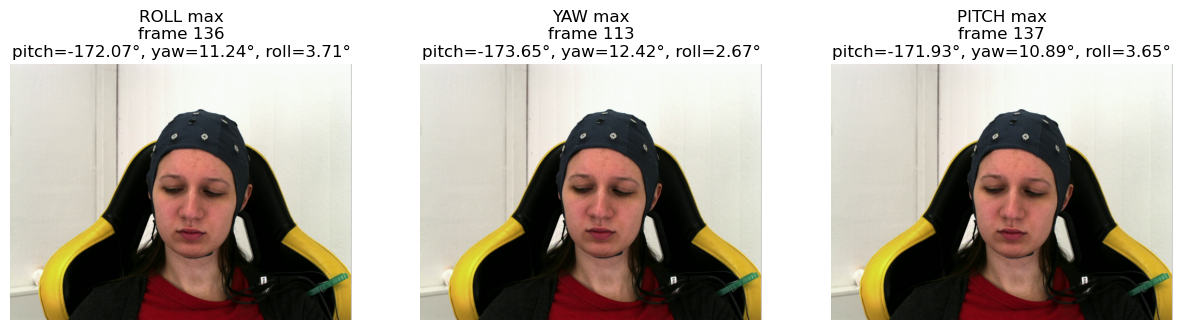


Summary of extracted frames (max values):
 roll: frame 136  pitch=-172.07°  yaw=11.24°  roll=3.71°  (saved frame_max_roll.png)
 yaw: frame 113  pitch=-173.65°  yaw=12.42°  roll=2.67°  (saved frame_max_yaw.png)
 pitch: frame 137  pitch=-171.93°  yaw=10.89°  roll=3.65°  (saved frame_max_pitch.png)


In [2]:
# install once (uncomment if needed)
# !pip install mediapipe opencv-python numpy pandas matplotlib

import cv2
import mediapipe as mp
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

def rotation_matrix_to_euler_angles(R):
  """
  Convert rotation matrix to Euler angles [pitch, yaw, roll] in degrees.
  """
  sy = math.sqrt(R[0,0] * R[0,0] + R[1,0] * R[1,0])
  singular = sy < 1e-6

  if not singular:
    x = math.atan2(R[2,1], R[2,2])   # pitch
    y = math.atan2(-R[2,0], sy)      # yaw
    z = math.atan2(R[1,0], R[0,0])   # roll
  else:
    x = math.atan2(-R[1,2], R[1,1])
    y = math.atan2(-R[2,0], sy)
    z = 0

  return np.degrees([x, y, z])  # pitch, yaw, roll


def compute_head_pose_from_video(video_path, fps_step=1, save_npy="headpose.npy", save_csv="headpose.csv"):
  """
  Processes video at video_path and returns an array of [frame_index, pitch, yaw, roll].
  Saves results as .npy and .csv.
  """
  mp_face = mp.solutions.face_mesh
  face_mesh = mp_face.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
  )

  cap = cv2.VideoCapture(video_path)
  if not cap.isOpened():
    raise ValueError(f"Cannot open video: {video_path}")

  results_list = []
  frame_idx = 0

  while True:
    ret, frame = cap.read()
    if not ret:
      break

    if frame_idx % fps_step != 0:
      frame_idx += 1
      continue

    h, w = frame.shape[:2]
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    detection = face_mesh.process(image_rgb)

    if detection.multi_face_landmarks and len(detection.multi_face_landmarks) > 0:
      landmarks = detection.multi_face_landmarks[0]

      idxs = [1, 152, 33, 263, 61, 291]
      image_points = []
      for idx in idxs:
        lm = landmarks.landmark[idx]
        x_px = int(lm.x * w)
        y_px = int(lm.y * h)
        image_points.append((x_px, y_px))

      image_points = np.array(image_points, dtype="double")

      model_points = np.array([
        (0.0, 0.0, 0.0),             # Nose tip
        (0.0, -63.6, -12.5),         # Chin
        (-43.3, 32.7, -26.0),        # Left eye outer
        (43.3, 32.7, -26.0),         # Right eye outer
        (-28.9, -28.9, -24.1),       # Left mouth corner
        (28.9, -28.9, -24.1)         # Right mouth corner
      ], dtype="double")

      focal_length = w
      center = (w / 2, h / 2)
      camera_matrix = np.array([
        [focal_length, 0, center[0]],
        [0, focal_length, center[1]],
        [0, 0, 1]
      ], dtype="double")

      dist_coeffs = np.zeros((4,1))

      success, rotation_vector, translation_vector = cv2.solvePnP(
        model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
      )

      if success:
        R_mat, _ = cv2.Rodrigues(rotation_vector)
        pitch, yaw, roll = rotation_matrix_to_euler_angles(R_mat)
        results_list.append([frame_idx, float(pitch), float(yaw), float(roll)])
      else:
        results_list.append([frame_idx, np.nan, np.nan, np.nan])
    else:
      results_list.append([frame_idx, np.nan, np.nan, np.nan])

    frame_idx += 1

  cap.release()
  face_mesh.close()

  arr = np.array(results_list, dtype=float)
  np.save(save_npy, arr)
  df = pd.DataFrame(arr, columns=["frame", "pitch_deg", "yaw_deg", "roll_deg"])
  df.to_csv(save_csv, index=False)

  return arr


def extract_and_show_max_frames(video_path, arr, out_prefix="frame_max"):
  """
  Given the head-pose array `arr` (columns: frame, pitch, yaw, roll),
  find the frame indices with maximum roll, yaw, and pitch (numeric max),
  extract the frames from the video, display them inline, print degrees,
  and save the images to disk.
  Returns a dict with info for each ('roll','yaw','pitch').
  """
  if arr.size == 0:
    raise ValueError("Empty headpose array")

  # columns: 0=frame, 1=pitch, 2=yaw, 3=roll
  info = {}
  cap = cv2.VideoCapture(video_path)
  if not cap.isOpened():
    raise ValueError(f"Cannot open video: {video_path}")

  names = [("roll", 3), ("yaw", 2), ("pitch", 1)]
  results_for_display = []

  for name, col in names:
    col_vals = arr[:, col]
    # check if all NaN
    if np.all(np.isnan(col_vals)):
      print(f"No valid values for {name} (all NaN). Skipping.")
      info[name] = None
      continue

    # index within arr of the maximum numeric value
    idx_in_arr = int(np.nanargmax(col_vals))
    frame_number = int(arr[idx_in_arr, 0])
    pitch_val = float(arr[idx_in_arr, 1])
    yaw_val = float(arr[idx_in_arr, 2])
    roll_val = float(arr[idx_in_arr, 3])

    # seek and read that frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    if not ret:
      print(f"Could not read frame {frame_number} for {name}.")
      info[name] = None
      continue

    # save image
    out_path = f"{out_prefix}_{name}.png"
    cv2.imwrite(out_path, frame)

    results_for_display.append((name, frame_number, frame, pitch_val, yaw_val, roll_val, out_path))

    info[name] = {
      "frame_index": frame_number,
      "pitch_deg": pitch_val,
      "yaw_deg": yaw_val,
      "roll_deg": roll_val,
      "image_path": out_path
    }

  cap.release()

  # Display the found frames side-by-side (if available)
  n = len(results_for_display)
  if n > 0:
    plt.figure(figsize=(5*n, 4))
    for i, (name, frame_number, frame, pitch_val, yaw_val, roll_val, out_path) in enumerate(results_for_display):
      ax = plt.subplot(1, n, i+1)
      rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      ax.imshow(rgb)
      ax.axis("off")
      ax.set_title(f"{name.upper()} max\nframe {frame_number}\npitch={pitch_val:.2f}°, yaw={yaw_val:.2f}°, roll={roll_val:.2f}°")
    plt.show()
  else:
    print("No frames to display (all values missing).")

  return info


# --------------------------
# Example usage in the notebook
# --------------------------
# 1) set your video path
video_path = "/media/villi/TOSHIBA EXT/orig_video/071309_w_21/071309_w_21-PA4-069.mp4"

# 2) compute head pose (this may take some time depending on video length)
headpose_array = compute_head_pose_from_video(video_path, fps_step=1)

# 3) extract and show frames where roll, yaw, pitch are maximum
info = extract_and_show_max_frames(video_path, headpose_array)

# 4) print summary
print("\nSummary of extracted frames (max values):")
for k, v in info.items():
  if v is None:
    print(f" {k}: no valid frame")
  else:
    print(f" {k}: frame {v['frame_index']}  pitch={v['pitch_deg']:.2f}°  yaw={v['yaw_deg']:.2f}°  roll={v['roll_deg']:.2f}°  (saved {v['image_path']})")

# headpose_array = compute_head_pose_from_video(video_path)

# print("Shape:", headpose_array.shape)
# print("First 5 rows:\n", headpose_array[:5])


In [4]:
# Live head-pose visualization in Jupyter notebook (2-space indentation)
# Press Interrupt (Ctrl+C) to stop the loop and release the camera.

import cv2
import mediapipe as mp
import numpy as np
import math
from PIL import Image
from IPython.display import display, clear_output
import time

def rotation_matrix_to_euler_angles(R):
  """
  Convert rotation matrix to Euler angles [pitch, yaw, roll] in degrees.
  """
  sy = math.sqrt(R[0,0] * R[0,0] + R[1,0] * R[1,0])
  singular = sy < 1e-6

  if not singular:
    x = math.atan2(R[2,1], R[2,2])   # pitch
    y = math.atan2(-R[2,0], sy)      # yaw
    z = math.atan2(R[1,0], R[0,0])   # roll
  else:
    x = math.atan2(-R[1,2], R[1,1])
    y = math.atan2(-R[2,0], sy)
    z = 0

  return np.degrees([x, y, z])  # pitch, yaw, roll


def draw_text_overlay(frame, pitch, yaw, roll):
  """
  Draw pitch, yaw, roll on the frame (top-left).
  """
  text1 = f"Pitch: {pitch:+.2f} deg"
  text2 = f"Yaw:   {yaw:+.2f} deg"
  text3 = f"Roll:  {roll:+.2f} deg"

  # background rectangle
  cv2.rectangle(frame, (5,5), (230,85), (0,0,0), -1)
  cv2.putText(frame, text1, (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
  cv2.putText(frame, text2, (10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
  cv2.putText(frame, text3, (10,75), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
  return frame


def live_headpose_webcam(display_width=640, display_height=480, camera_index=0, fps_limit=15):
  """
  Capture webcam, compute head pose per frame, overlay angles, and display in the notebook.
  - display_width, display_height: desired display resolution (will be used to resize frames for display).
  - camera_index: webcam device id (0 usually).
  - fps_limit: approximate maximum frames per second to process/display.
  Stop by interrupting the cell (Ctrl+C).
  """
  mp_face = mp.solutions.face_mesh
  face_mesh = mp_face.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    refine_landmarks=False,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
  )

  cap = cv2.VideoCapture(camera_index)
  if not cap.isOpened():
    raise RuntimeError("Could not open webcam (camera_index={})".format(camera_index))

  # try to set resolution (may be ignored by some cameras/drivers)
  cap.set(cv2.CAP_PROP_FRAME_WIDTH, display_width)
  cap.set(cv2.CAP_PROP_FRAME_HEIGHT, display_height)

  prev_time = 0
  try:
    while True:
      start_time = time.time()

      ret, frame = cap.read()
      if not ret:
        print("Failed to read frame from webcam.")
        break

      # Optionally resize for speed / consistent display
      frame = cv2.resize(frame, (display_width, display_height))

      h, w = frame.shape[:2]
      image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      detection = face_mesh.process(image_rgb)

      pitch = 0.0
      yaw = 0.0
      roll = 0.0

      if detection.multi_face_landmarks and len(detection.multi_face_landmarks) > 0:
        landmarks = detection.multi_face_landmarks[0]

        # indices used in previous scripts
        idxs = [1, 152, 33, 263, 61, 291]
        image_points = []
        for idx in idxs:
          lm = landmarks.landmark[idx]
          x_px = int(lm.x * w)
          y_px = int(lm.y * h)
          image_points.append((x_px, y_px))

        image_points = np.array(image_points, dtype="double")

        model_points = np.array([
          (0.0, 0.0, 0.0),             # Nose tip
          (0.0, -63.6, -12.5),         # Chin
          (-43.3, 32.7, -26.0),        # Left eye outer
          (43.3, 32.7, -26.0),         # Right eye outer
          (-28.9, -28.9, -24.1),       # Left mouth corner
          (28.9, -28.9, -24.1)         # Right mouth corner
        ], dtype="double")

        focal_length = w
        center = (w / 2, h / 2)
        camera_matrix = np.array([
          [focal_length, 0, center[0]],
          [0, focal_length, center[1]],
          [0, 0, 1]
        ], dtype="double")

        dist_coeffs = np.zeros((4,1))

        try:
          success, rotation_vector, translation_vector = cv2.solvePnP(
            model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE
          )
          if success:
            R_mat, _ = cv2.Rodrigues(rotation_vector)
            pitch, yaw, roll = rotation_matrix_to_euler_angles(R_mat)

            # Optionally draw small landmarks used for solvePnP
            for (x,y) in image_points.astype(int):
              cv2.circle(frame, (int(x), int(y)), 2, (0,255,0), -1)
        except Exception as e:
          # in case solvePnP fails for a frame, we simply continue and display zeros or previous values
          # print("solvePnP error:", e)
          pass

      # Overlay text with angles
      out_frame = draw_text_overlay(frame.copy(), pitch, yaw, roll)

      # Convert to RGB PIL image for inline display
      display_img = cv2.cvtColor(out_frame, cv2.COLOR_BGR2RGB)
      pil_img = Image.fromarray(display_img)

      # Display (clear previous output to update inline)
      clear_output(wait=True)
      display(pil_img)

      # frame rate limiting (simple)
      elapsed = time.time() - start_time
      min_frame_time = 1.0 / float(max(1, fps_limit))
      if elapsed < min_frame_time:
        time.sleep(min_frame_time - elapsed)

  except KeyboardInterrupt:
    # user interrupted with Ctrl+C
    print("Interrupted by user, stopping webcam.")
  finally:
    cap.release()
    face_mesh.close()
    clear_output(wait=True)
    print("Webcam released. Done.")


# Run the live display (call the function)
# If your notebook uses a different camera index, change camera_index=0 to another integer.
live_headpose_webcam(display_width=640, display_height=480, camera_index=0, fps_limit=10)


Webcam released. Done.


In [3]:
import torch
import torchsort
print(torch.__version__)        # should show 2.5.* (and +cu118)
print(torch.version.cuda)       # should show '11.8'
# print(torchsort)    # should show the version installed

# Try a quick test
x = torch.randn(4, 10, device='cuda')
y = torchsort.soft_rank(x)
print(y.shape)                  # should be (4,10)


2.5.1
11.8
torch.Size([4, 10])


In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


2.5.1
11.8
True


In [ ]:
import sys
import os

video_folder_path = "partA/video/video_frontalized_interpolated_mirror"
for root, dirs, files in os.walk(video_folder_path):
  for file in files:
    if file.endswith(".mp4"):
      if '$' in file:
        # remove the file
        os.remove(os.path.join(root, file))
        print(f"Removed file: {os.path.join(root, file)}")

# TEST Accuracy

In [ ]:
import torch
import numpy as np
import custom.tools as tools 
from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
)


# Test case 1: Simple multi-class classification
true_labels_1 = np.array([0, 1, 2, 0, 1, 2, 0, 1, 2])
predicted_labels_1 = np.array([0, 1, 2, 0, 2, 1, 0, 1, 2])
num_classes_1 = 3
cm_torch_1 = torch.tensor(confusion_matrix(true_labels_1, predicted_labels_1))
results_1 = tools.evaluate_classification_from_confusion_matrix(cm_torch_1)

print("Test Case 1:")
print("Confusion Matrix:\n", cm_torch_1)

sklearn_precision_1 = precision_score(true_labels_1, predicted_labels_1, average=None)
sklearn_recall_1 = recall_score(true_labels_1, predicted_labels_1, average=None)
sklearn_accuracy_1 = accuracy_score(true_labels_1, predicted_labels_1)
sklearn_macro_precision_1 = precision_score(true_labels_1, predicted_labels_1, average='macro')
sklearn_macro_recall_1 = recall_score(true_labels_1, predicted_labels_1, average='macro')
sklearn_micro_precision_1 = precision_score(true_labels_1, predicted_labels_1, average='micro')
sklearn_micro_recall_1 = recall_score(true_labels_1, predicted_labels_1, average='micro')
sklearn_weighted_precision_1 = precision_score(true_labels_1, predicted_labels_1, average='weighted')
sklearn_weighted_recall_1 = recall_score(true_labels_1, predicted_labels_1, average='weighted')

print("Your Results:")
for key, value in results_1.items():
    print(f"{key}: {value}")

print("\nScikit-learn Results:")
print(f"precision_per_class: {sklearn_precision_1}")
print(f"recall_per_class: {sklearn_recall_1}")
print(f"macro_precision: {sklearn_macro_precision_1}")
print(f"macro_recall: {sklearn_macro_recall_1}")
print(f"micro_precision: {sklearn_micro_precision_1}")
print(f"micro_recall: {sklearn_micro_recall_1}")
print(f"weighted_precision: {sklearn_weighted_precision_1}")
print(f"weighted_recall: {sklearn_weighted_recall_1}")
print(f"accuracy: {sklearn_accuracy_1}")

# Comparison for Test Case 1
print("\nComparison with Scikit-learn (Test Case 1):")
np.testing.assert_allclose(results_1['precision_per_class'], sklearn_precision_1, err_msg="Precision per class mismatch")
np.testing.assert_allclose(results_1['recall_per_class'], sklearn_recall_1, err_msg="Recall per class mismatch")
np.testing.assert_allclose(results_1['macro_precision'], sklearn_macro_precision_1, err_msg="Macro precision mismatch")
np.testing.assert_allclose(results_1['macro_recall'], sklearn_macro_recall_1, err_msg="Macro recall mismatch")
np.testing.assert_allclose(results_1['micro_precision'], sklearn_micro_precision_1, err_msg="Micro precision mismatch")
np.testing.assert_allclose(results_1['micro_recall'], sklearn_micro_recall_1, err_msg="Micro recall mismatch")
np.testing.assert_allclose(results_1['weighted_precision'], sklearn_weighted_precision_1, err_msg="Weighted precision mismatch")
np.testing.assert_allclose(results_1['weighted_recall'], sklearn_weighted_recall_1, err_msg="Weighted recall mismatch")
np.testing.assert_allclose(results_1['accuracy'], sklearn_accuracy_1, err_msg="Accuracy mismatch")
print("All values in Test Case 1 match scikit-learn.")

print("-" * 50)

# Test case 2: Binary classification
true_labels_2 = np.array([0, 0, 1, 1, 1])
predicted_labels_2 = np.array([0, 1, 1, 0, 1])
num_classes_2 = 2
cm_torch_2 = torch.tensor(confusion_matrix(true_labels_2, predicted_labels_2))
results_2 = tools.evaluate_classification_from_confusion_matrix(cm_torch_2)

print("\nTest Case 2 (Binary Classification):")
print("Confusion Matrix:\n", cm_torch_2)

sklearn_precision_2 = precision_score(true_labels_2, predicted_labels_2, average=None)
sklearn_recall_2 = recall_score(true_labels_2, predicted_labels_2, average=None)
sklearn_accuracy_2 = accuracy_score(true_labels_2, predicted_labels_2)
sklearn_macro_precision_2 = precision_score(true_labels_2, predicted_labels_2, average='macro')
sklearn_macro_recall_2 = recall_score(true_labels_2, predicted_labels_2, average='macro')
sklearn_micro_precision_2 = precision_score(true_labels_2, predicted_labels_2, average='micro')
sklearn_micro_recall_2 = recall_score(true_labels_2, predicted_labels_2, average='micro')
sklearn_weighted_precision_2 = precision_score(true_labels_2, predicted_labels_2, average='weighted')
sklearn_weighted_recall_2 = recall_score(true_labels_2, predicted_labels_2, average='weighted')

print("Your Results:")
for key, value in results_2.items():
    print(f"{key}: {value}")

print("\nScikit-learn Results:")
print(f"precision_per_class: {sklearn_precision_2}")
print(f"recall_per_class: {sklearn_recall_2}")
print(f"macro_precision: {sklearn_macro_precision_2}")
print(f"macro_recall: {sklearn_macro_recall_2}")
print(f"micro_precision: {sklearn_micro_precision_2}")
print(f"micro_recall: {sklearn_micro_recall_2}")
print(f"weighted_precision: {sklearn_weighted_precision_2}")
print(f"weighted_recall: {sklearn_weighted_recall_2}")
print(f"accuracy: {sklearn_accuracy_2}")

# Comparison for Test Case 2
print("\nComparison with Scikit-learn (Test Case 2):")
np.testing.assert_allclose(results_2['precision_per_class'], sklearn_precision_2, err_msg="Precision per class mismatch")
np.testing.assert_allclose(results_2['recall_per_class'], sklearn_recall_2, err_msg="Recall per class mismatch")
np.testing.assert_allclose(results_2['macro_precision'], sklearn_macro_precision_2, err_msg="Macro precision mismatch")
np.testing.assert_allclose(results_2['macro_recall'], sklearn_macro_recall_2, err_msg="Macro recall mismatch")
np.testing.assert_allclose(results_2['micro_precision'], sklearn_micro_precision_2, err_msg="Micro precision mismatch")
np.testing.assert_allclose(results_2['micro_recall'], sklearn_micro_recall_2, err_msg="Micro recall mismatch")
np.testing.assert_allclose(results_2['weighted_precision'], sklearn_weighted_precision_2, err_msg="Weighted precision mismatch")
np.testing.assert_allclose(results_2['weighted_recall'], sklearn_weighted_recall_2, err_msg="Weighted recall mismatch")
np.testing.assert_allclose(results_2['accuracy'], sklearn_accuracy_2, err_msg="Accuracy mismatch")
print("All values in Test Case 2 match scikit-learn.")

print("-" * 50)

# Test case 3: Imbalanced dataset
true_labels_3 = np.array([0, 0, 0, 0, 1, 1])
predicted_labels_3 = np.array([0, 0, 1, 0, 1, 0])
num_classes_3 = 2
cm_torch_3 = torch.tensor(confusion_matrix(true_labels_3, predicted_labels_3))
results_3 = tools.evaluate_classification_from_confusion_matrix(cm_torch_3)

print("\nTest Case 3 (Imbalanced Dataset):")
print("Confusion Matrix:\n", cm_torch_3)

sklearn_precision_3 = precision_score(true_labels_3, predicted_labels_3, average=None)
sklearn_recall_3 = recall_score(true_labels_3, predicted_labels_3, average=None)
sklearn_accuracy_3 = accuracy_score(true_labels_3, predicted_labels_3)
sklearn_macro_precision_3 = precision_score(true_labels_3, predicted_labels_3, average='macro')
sklearn_macro_recall_3 = recall_score(true_labels_3, predicted_labels_3, average='macro')
sklearn_micro_precision_3 = precision_score(true_labels_3, predicted_labels_3, average='micro')
sklearn_micro_recall_3 = recall_score(true_labels_3, predicted_labels_3, average='micro')
sklearn_weighted_precision_3 = precision_score(true_labels_3, predicted_labels_3, average='weighted')
sklearn_weighted_recall_3 = recall_score(true_labels_3, predicted_labels_3, average='weighted')

print("Your Results:")
for key, value in results_3.items():
    print(f"{key}: {value}")

print("\nScikit-learn Results:")
print(f"precision_per_class: {sklearn_precision_3}")
print(f"recall_per_class: {sklearn_recall_3}")
print(f"macro_precision: {sklearn_macro_precision_3}")
print(f"macro_recall: {sklearn_macro_recall_3}")
print(f"micro_precision: {sklearn_micro_precision_3}")
print(f"micro_recall: {sklearn_micro_recall_3}")
print(f"weighted_precision: {sklearn_weighted_precision_3}")
print(f"weighted_recall: {sklearn_weighted_recall_3}")
print(f"accuracy: {sklearn_accuracy_3}")

# Comparison for Test Case 3
print("\nComparison with Scikit-learn (Test Case 3):")
np.testing.assert_allclose(results_3['precision_per_class'], sklearn_precision_3, err_msg="Precision per class mismatch")
np.testing.assert_allclose(results_3['recall_per_class'], sklearn_recall_3, err_msg="Recall per class mismatch")
np.testing.assert_allclose(results_3['macro_precision'], sklearn_macro_precision_3, err_msg="Macro precision mismatch")
np.testing.assert_allclose(results_3['macro_recall'], sklearn_macro_recall_3, err_msg="Macro recall mismatch")
np.testing.assert_allclose(results_3['micro_precision'], sklearn_micro_precision_3, err_msg="Micro precision mismatch")
np.testing.assert_allclose(results_3['micro_recall'], sklearn_micro_recall_3, err_msg="Micro recall mismatch")
np.testing.assert_allclose(results_3['weighted_precision'], sklearn_weighted_precision_3, err_msg="Weighted precision mismatch")
np.testing.assert_allclose(results_3['weighted_recall'], sklearn_weighted_recall_3, err_msg="Weighted recall mismatch")
np.testing.assert_allclose(results_3['accuracy'], sklearn_accuracy_3, err_msg="Accuracy mismatch")
print("All values in Test Case 3 match scikit-learn.")